# Scratch work for TensorFlow skills test (classification)

- Author: Chris Hodapp
- Date: 2017-11-15
- For SharpestMinds/Yazabi

## Links:

- [human-activity-recognition-using-smartphones (GitHub)](https://github.com/pdelboca/human-activity-recognition-using-smartphones)
- [Data source (60 MB ZIP)](https://d396qusza40orc.cloudfront.net/getdata%2Fprojectfiles%2FUCI%20HAR%20Dataset.zip)
- [Human Activity Recognition Using Smartphones (UCI)](http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)
- [MLconf 2015 Seattle: When do I use zero-mean/unit variance normalization vs unit L1/L2 normalization?
](https://www.quora.com/MLconf-2015-Seattle-When-do-I-use-zero-mean-unit-variance-normalization-vs-unit-L1-L2-normalization)

## Boilerplate

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sklearn.decomposition
import sklearn.externals
import sklearn.manifold
import sklearn.preprocessing

## Data Loading

In [3]:
# I really don't feel like copying these into the document, so
# instead load them from the included file:
feature_list = pd.read_csv("UCI HAR Dataset/features.txt",
    index_col=0, header=None, sep=" ")
# ...and sanitize them so Pandas can use them for column names:
san_dict = {ord("("): "", ord(")"): "", ord("-"): "_", ord(","): "_"}
features = list(f.translate(san_dict) for f in feature_list.iloc[:,0])
features

['tBodyAcc_mean_X',
 'tBodyAcc_mean_Y',
 'tBodyAcc_mean_Z',
 'tBodyAcc_std_X',
 'tBodyAcc_std_Y',
 'tBodyAcc_std_Z',
 'tBodyAcc_mad_X',
 'tBodyAcc_mad_Y',
 'tBodyAcc_mad_Z',
 'tBodyAcc_max_X',
 'tBodyAcc_max_Y',
 'tBodyAcc_max_Z',
 'tBodyAcc_min_X',
 'tBodyAcc_min_Y',
 'tBodyAcc_min_Z',
 'tBodyAcc_sma',
 'tBodyAcc_energy_X',
 'tBodyAcc_energy_Y',
 'tBodyAcc_energy_Z',
 'tBodyAcc_iqr_X',
 'tBodyAcc_iqr_Y',
 'tBodyAcc_iqr_Z',
 'tBodyAcc_entropy_X',
 'tBodyAcc_entropy_Y',
 'tBodyAcc_entropy_Z',
 'tBodyAcc_arCoeff_X_1',
 'tBodyAcc_arCoeff_X_2',
 'tBodyAcc_arCoeff_X_3',
 'tBodyAcc_arCoeff_X_4',
 'tBodyAcc_arCoeff_Y_1',
 'tBodyAcc_arCoeff_Y_2',
 'tBodyAcc_arCoeff_Y_3',
 'tBodyAcc_arCoeff_Y_4',
 'tBodyAcc_arCoeff_Z_1',
 'tBodyAcc_arCoeff_Z_2',
 'tBodyAcc_arCoeff_Z_3',
 'tBodyAcc_arCoeff_Z_4',
 'tBodyAcc_correlation_X_Y',
 'tBodyAcc_correlation_X_Z',
 'tBodyAcc_correlation_Y_Z',
 'tGravityAcc_mean_X',
 'tGravityAcc_mean_Y',
 'tGravityAcc_mean_Z',
 'tGravityAcc_std_X',
 'tGravityAcc_std_Y',
 't

In [4]:
def read_features(fname):
    return pd.read_csv(fname, delim_whitespace=True, header=None,
                       names=features, index_col=None)

train_X_summary = read_features("UCI HAR Dataset/train/X_train.txt")
test_X_summary = read_features("UCI HAR Dataset/test/X_test.txt")

In [5]:
def read_labels(fname):
    df = pd.read_csv(fname, header=None)
    # We just want the series, not the dataframe:
    return df.iloc[:, 0]

train_y = read_labels("UCI HAR Dataset/train/y_train.txt")
test_y = read_labels("UCI HAR Dataset/test/y_test.txt")

In [6]:
def read_accel(s, train_or_test):
    fname = "UCI HAR Dataset/{0}/Inertial Signals/total_acc_{1}_{0}.txt".\
        format(train_or_test, s)
    # It's a bit confusing to have column names that are also numbers,
    # so use accX_0...accX_127 (for instance):
    names = ["acc" + s.upper() + "_" + str(i) for i in range(128)]
    df = pd.read_csv(fname, delim_whitespace=True, header=None,
                     index_col=None, names=names)
    assert df.shape[1] == 128
    return df

train_accels = [read_accel(v, "train") for v in ("x","y","z")]
test_accels  = [read_accel(v, "test")  for v in ("x","y","z")]

In [7]:
train_X = pd.concat([train_X_summary] + train_accels, axis=1)
test_X  = pd.concat([test_X_summary]  + test_accels,  axis=1)

In [8]:
# Standardize to unit variance & zero mean:
ss = sklearn.preprocessing.StandardScaler()
train_X.iloc[:, :] = ss.fit_transform(train_X)
test_X.iloc[:, :] = ss.transform(test_X)

In [9]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 945 entries, tBodyAcc_mean_X to accZ_127
dtypes: float64(945)
memory usage: 53.0 MB


In [10]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 945 entries, tBodyAcc_mean_X to accZ_127
dtypes: float64(945)
memory usage: 21.2 MB


## Manifold plots

In [11]:
def plot_embedding(embed, labels=train_y):
    cmap = matplotlib.colors.ListedColormap(['k','b','y','g','r','m'])
    plt.scatter(
        embed[:,0], embed[:,1], s=5,
        c=labels,
        cmap=cmap
    )
    plt.show()

In [12]:
mds_model_fname = "train_mds.pkl"
if os.path.isfile(mds_model_fname):
    embed_mds = sklearn.externals.joblib.load(mds_model_fname)
else:
    # This takes a few minutes to run fully:
    mds = sklearn.manifold.MDS(n_components=2)
    embed_mds = mds.fit_transform(train_X)
    sklearn.externals.joblib.dump(embed_mds, mds_model_fname)

In [13]:
isomap = sklearn.manifold.Isomap(n_components=2)
embed_iso = isomap.fit_transform(train_X)

In [14]:
embed_lle, _ = sklearn.manifold.locally_linear_embedding(train_X, n_components=2, n_neighbors=5)

In [15]:
spectral = sklearn.manifold.SpectralEmbedding(n_components=2)
embed_sp = spectral.fit_transform(train_X)

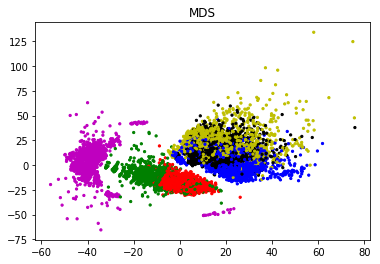

In [16]:
plt.title("MDS")
plot_embedding(embed_mds)

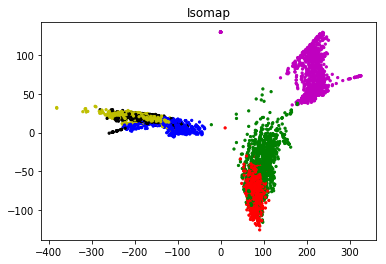

In [17]:
plt.title("Isomap")
plot_embedding(embed_iso)

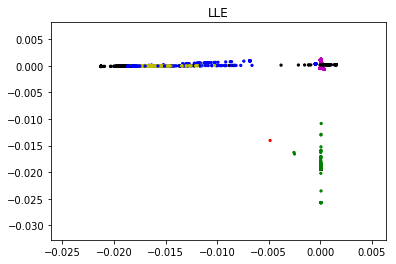

In [18]:
plt.title("LLE")
plot_embedding(embed_lle)

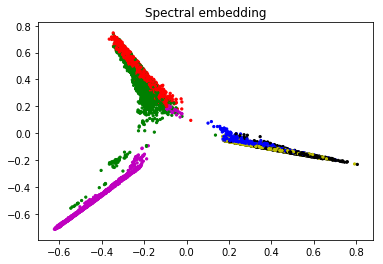

In [19]:
plt.title("Spectral embedding")
plot_embedding(embed_sp)

- t-SNE, according to [this](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b), should have the data's dimensions reduced with PCA (to ~50) if it is very large:

In [20]:
pca50 = sklearn.decomposition.PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
print("Variance explained: {0:.1f}%".format(
    pca50.explained_variance_ratio_.sum() * 100))

Variance explained: 88.9%


In [21]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=50)
idxs_reduced = np.random.choice(train_X_pca50.shape[0], 3000)
train_X_pca50_reduced = train_X_pca50[idxs_reduced]
train_y_reduced = train_y[idxs_reduced]
embed_tsne = tsne.fit_transform(train_X_pca50_reduced)

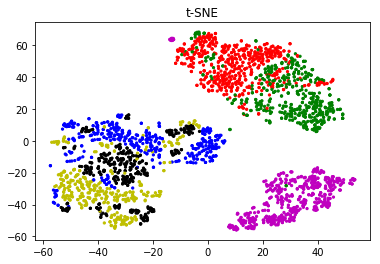

In [22]:
plt.title("t-SNE")
plot_embedding(embed_tsne, train_y_reduced)